<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/split-step-fourier-method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
plt.style.use('ggplot')

In [0]:
################### Physical Parameters  ########################
Ip = 4**2;                           #peak intensity
Ib = 1.0;                             #background illumination
Lambda = 0.5e-6;                      #wavelength
k0 = 2*np.pi/Lambda;                  #vacuum wavevector
n0 = 1;                               #background index of refraction

Lz = 5;                               #computational length of sample
Lx = 30e-3;                           #computational width of sample

Chirp = -0.0*6*230000.0;              #input linear chirp parameter

# inputposition=-0*10^(-6);           #input position
h = 0.67e-3;
inputposition = +h/2;                 #input position

Radius = 1e-3;


In [0]:
################## Computational Parameters #############

nstepx = 1*1024;                #number of transverse grid points
nstepz = 20;     #200            #number of longitudinal propagation steps
deltax = Lx/nstepx;
deltaz = Lz/nstepz;    #the resolution in the z direction, IMPORTANT
deltaf = 1/Lx;                  #spatial frequency step

In [0]:
##########################  GENERAL GRID SET-UP  ##########################

z = np.arange(0, Lz, deltaz)                #z grid
x = -Lx/2 + deltax/2+(np.arange(0, nstepx, 1))*deltax;                       # x array

X, Y = np.meshgrid(x,x);

In [0]:
##########################  Dispersive Step Setup #########################

ntx = 0;             
kx = np.zeros(nstepx)                                          #this is to get rid of fftshifts and the sort
for nn in range(nstepx):
    ikx = nn - ntx;
    kx[nn] = 2*np.pi*deltaf*ikx;
    if nn + 1 - nstepx/2 == 0 :
      ntx = nstepx;

KX, KY = np.meshgrid(kx, kx);

ArgumentOfPropagator  =  ((k0*n0)**(-1)*(KX**2+KY**2))*(deltaz/2.);             
Propagator = np.cos(ArgumentOfPropagator)+1j*np.sin(ArgumentOfPropagator);

In [0]:
####################### INPUT FIELDS DEFINITION  #########################
InputField=np.sqrt(Ip)*np.exp(1j*Chirp*X-(X-inputposition)**2./(w0**2)-(Y)**2./(w0**2));

MatrixAppoggio = np.zeros(shape=(nstepx, nstepx, nstepz))
MatrixAppoggio[..., 0] = np.abs(InputField)**2

In [0]:
from matplotlib.colors import LinearSegmentedColormap

# we use a colormap similar to the one observed in lab
# when using lasers, black with no light, red at maximum intensity

cdict = {'red':   [[0.0,  0.0, 0.0],
                   [1.0,  1.0, 1.0]],
         'green': [[0.0,  0.0, 0.0],
                   [1.0,  0.0, 0.0]],
         'blue':  [[0.0,  0.0, 0.0],
                   [1.0,  0.0, 0.0]]}

cmap = LinearSegmentedColormap('testCmap', segmentdata=cdict, N=256)

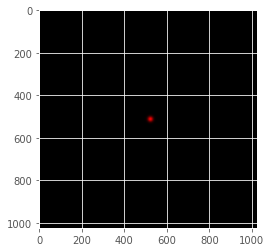

In [147]:
plt.imshow(abs(InputField)**2, cmap=cmap)

In [0]:
fft2, ifft2= np.fft.fft2, np.fft.ifft2

In [149]:
####################################################################)#
######                    PROPAGATION LOOP                  ########
####################################################################
tstart = time.time()
for hh in range(nstepz):
    
    InputFieldTransform = fft2(InputField)
    InputFieldTransform = InputFieldTransform*Propagator;
    InputField = ifft2(InputFieldTransform)

    MatrixAppoggio[..., hh] = abs(InputField)**2;
    
print(f"Lasted {time.time()-tstart} seconds")
inputpower = np.sum(MatrixAppoggio[...,1])
outputpower = np.sum(MatrixAppoggio[...,-1])

energy_gap = (outputpower-inputpower)/(outputpower+inputpower)
if energy_gap != 0:
  print(energy_gap)

Lasted 28.110009908676147 seconds
6.212020862233393e-15


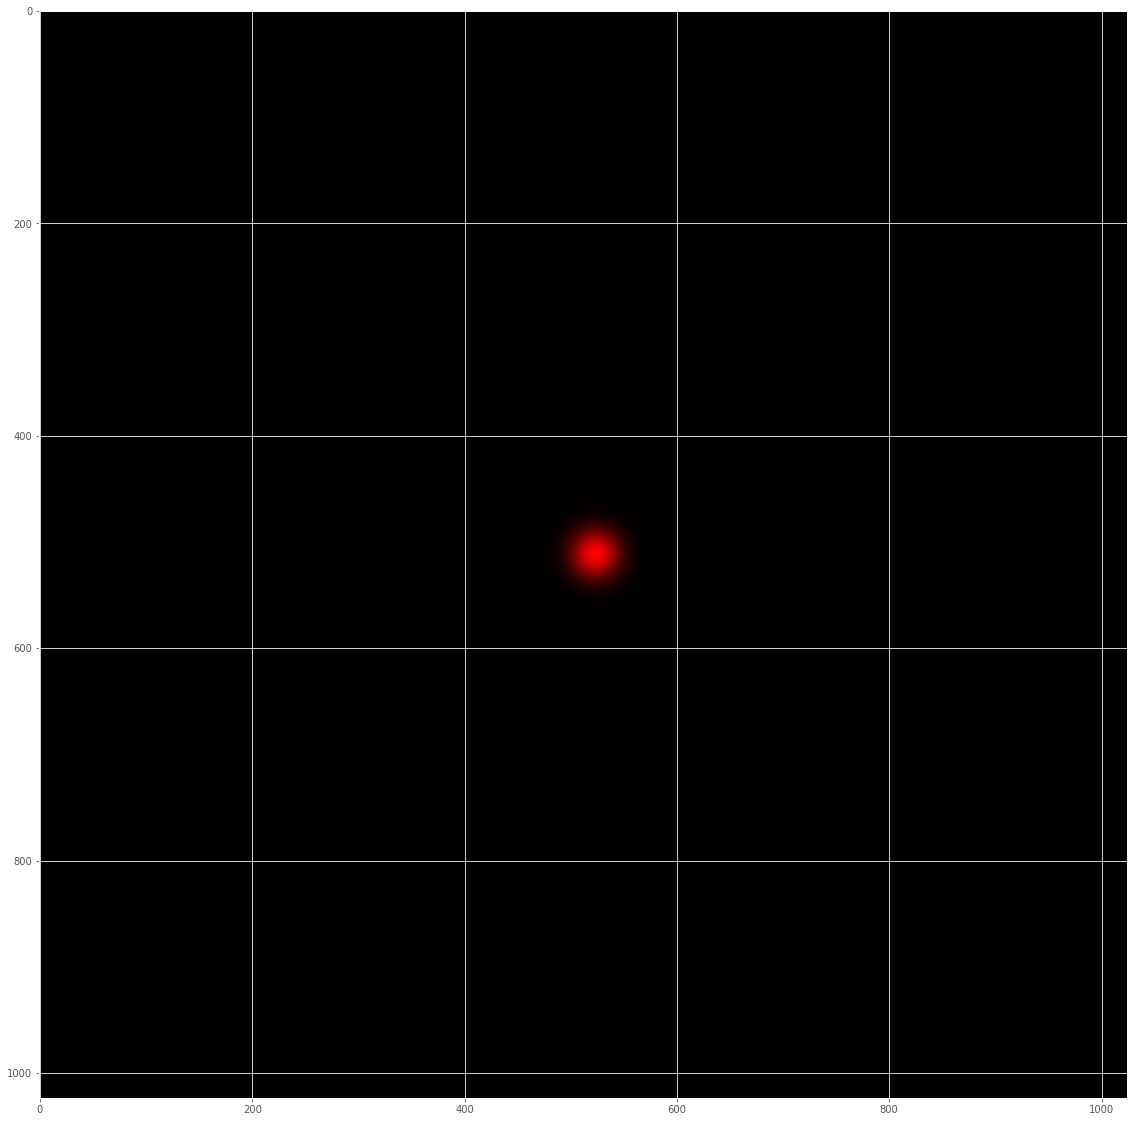

In [150]:
plt.close()
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(MatrixAppoggio[...,-1], cmap=cmap)